# Graph V

In [12]:
from typing import Dict, List, TypedDict
from langgraph.graph import StateGraph, END  # type: ignore
import random

In [13]:
class AgentState(TypedDict):
  name: str
  number: List[int]
  counter: int

In [14]:
def greeting_node(state: AgentState) -> AgentState:
  """Greeting node which says hi to the user"""
  state["name"] = f"Hi there, {state['name']}!"
  state["counter"] = 0

  return state

def random_node(state: AgentState) -> AgentState:
    """Generate a random number from 1 to 10"""
    state["number"].append(random.randint(1, 10))
    state["counter"] += 1

    return state


def should_continue(state: AgentState) -> str:
    """Function to decide what to do next based on the counter value"""
    if state["counter"] < 5:
      print("Entering loop", state["counter"])
      return "loop"
    else:
      return "exit"

In [ ]:
# greeting -> random -> random -> random -> random -> random -> exit

In [17]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")

graph.set_entry_point("greeting")

graph.add_conditional_edges(
  "random",
  should_continue,
  {
    "loop": "random",
    "exit": END
  }
)

app = graph.compile()

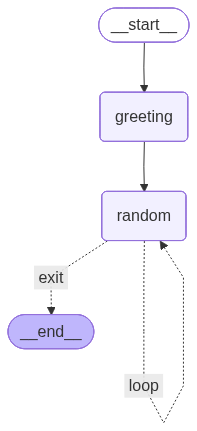

In [20]:
from IPython.display import display, Image  # type: ignore

display(Image(app.get_graph().draw_mermaid_png()))  # Visualize the graph structure

In [25]:
app.invoke({"name": "Alice", "number": [], "counter": 0})

Entering loop 1
Entering loop 2
Entering loop 3
Entering loop 4


{'name': 'Hi there, Alice!', 'number': [8, 6, 9, 10, 5], 'counter': 5}

### Exercise for graph 5

**Your task**:

Make the graph on the right! You need to implement an **Automatic Higher or Lower Game**.

Set the bounds to between 1 to 20. The Graph has to keep guessing (max number of guesses is 7) where if the guess is correct, then it stops, but if not we keep looping until we hit the max limit of 7.

Each time a number of guessed, the hind node should say higher or lower and the graph should account for this information and guess the next guess accordingly.

**Input**: ("player_name": "Student", "guesses": [], "attempts": 0, "lower_bound": 1)

*Hint*: It will need to adjust its bounds after every guess based on the hint provided by the hint node.

In [14]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, END  # type: ignore
import random

In [15]:
class GameState(TypedDict):
  player_name: str
  target_number: int
  guesses: List[int]
  attempts: int
  hint: str
  lower_bound: int
  upper_bound: int

In [16]:
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1
    state["upper_bound"] = 20
    print(
        f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20."
    )
    return state

In [17]:
def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""

    possible_guesses = [
        i
        for i in range(state["lower_bound"], state["upper_bound"] + 1)
        if i not in state["guesses"]
    ]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:

        guess = random.randint(state["lower_bound"], state["upper_bound"])

    state["guesses"].append(guess)
    state["attempts"] += 1
    print(
        f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})"
    )
    return state

In [18]:
def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]

    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"

        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")

    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"

        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = (
            f"Correct! You found the number {target} in {state['attempts']} attempts."
        )
        print(f"Success! {state['hint']}")

    return state

In [19]:
def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""

    # There are 2 end conditions - either 7 is reached or the correct number is guessed

    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(
            f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}"
        )
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [20]:
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")


graph.add_conditional_edges(
    "hint_node", should_continue, {"continue": "guess", "end": END}
)

graph.set_entry_point("setup")
app = graph.compile()

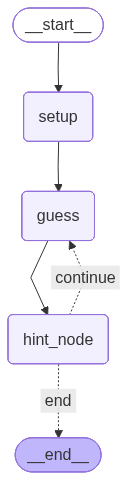

In [21]:
from IPython.display import display, Image  # type: ignore
display(Image(app.get_graph().draw_mermaid_png()))  # Visualize the graph structure

In [23]:
app.invoke({"player_name": "Alice", "random_number": 15, "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20, "hint": ""})

Welcome, Alice! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 20 (Current range: 1-20)
Hint: The number 20 is too high. Try lower!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 3 (Current range: 1-19)
Hint: The number 3 is too low. Try higher!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 19 (Current range: 4-19)
Hint: The number 19 is too high. Try lower!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 14 (Current range: 4-18)
Success! Correct! You found the number 14 in 4 attempts.
GAME OVER: Number found!


{'player_name': 'Welcome, Alice!',
 'target_number': 14,
 'guesses': [20, 3, 19, 14],
 'attempts': 4,
 'hint': 'Correct! You found the number 14 in 4 attempts.',
 'lower_bound': 4,
 'upper_bound': 18}